In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
from ydata_profiling import ProfileReport as ydata_prof
from pandas_profiling import ProfileReport as pd_prof

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [86]:
df = pd.read_csv('eo_context_4.csv', parse_dates=['DATE'])

Wanted to get summaries before I broke them into groups. I found four missing values, so I just did fillna(0)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    172 non-null    datetime64[ns]
 1   display_s               172 non-null    float64       
 2   brands_branded_s        172 non-null    float64       
 3   brands_category         172 non-null    float64       
 4   products_auto_s         172 non-null    float64       
 5   products_brand_s        172 non-null    float64       
 6   products_category_s     172 non-null    float64       
 7   products_competitive_s  172 non-null    float64       
 8   revenue                 172 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 12.2 KB


In [88]:
# df.drop(['brands_auto_s'], axis=1, inplace=True)

In [89]:
df.fillna(0, inplace=True)

I checked for a column with too many zeroes (I haven't decided a threshold for that yet).

In [90]:
print((df == 0).sum() / len(df))

DATE                      0.000000
display_s                 0.267442
brands_branded_s          0.011628
brands_category           0.127907
products_auto_s           0.156977
products_brand_s          0.000000
products_category_s       0.000000
products_competitive_s    0.000000
revenue                   0.000000
dtype: float64


brands_category_s is all zeroes and will be dropped

In [91]:
# df.drop(['brands_category_s'], axis=1, inplace=True)

In [92]:
print('Missing Values')
print(df.isnull().sum() / len(df) * 100)

Missing Values
DATE                      0.0
display_s                 0.0
brands_branded_s          0.0
brands_category           0.0
products_auto_s           0.0
products_brand_s          0.0
products_category_s       0.0
products_competitive_s    0.0
revenue                   0.0
dtype: float64


In [93]:
df_spend = df[['display_s', 'brands_branded_s', 'products_category_s', 'products_competitive_s', 'products_auto_s']]
df_no_dep = df.drop(['revenue', 'DATE'], axis=1)
df_no_date = df[['display_s', 'brands_branded_s', 'products_category_s', 'products_competitive_s', 'products_auto_s', 'revenue']]

These results make sense because product_category_s has quite a few zeroes.

In [94]:
df.nunique()

DATE                      172
display_s                 127
brands_branded_s          171
brands_category           151
products_auto_s           144
products_brand_s          172
products_category_s       172
products_competitive_s    172
revenue                   172
dtype: int64

Looking for sufficient variance here. With units, they tend to have less variance.
We can verify variance with the KDE plots overlaying the histograms.

In [95]:
df.describe()

,DATE,display_s,brands_branded_s,brands_category,products_auto_s,products_brand_s,products_category_s,products_competitive_s,revenue
count,172,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,2021-05-05 12:00:00,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047,95278.449302
min,2019-09-15 00:00:00,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000,32134.510000
25%,2020-07-10 06:00:00,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000,76007.087500
50%,2021-05-05 12:00:00,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000,93945.470000
75%,2022-02-28 18:00:00,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000,109930.700000
max,2022-12-25 00:00:00,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000,174302.250000
std,NaN,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411,27984.974843


<Axes: xlabel='revenue', ylabel='Count'>

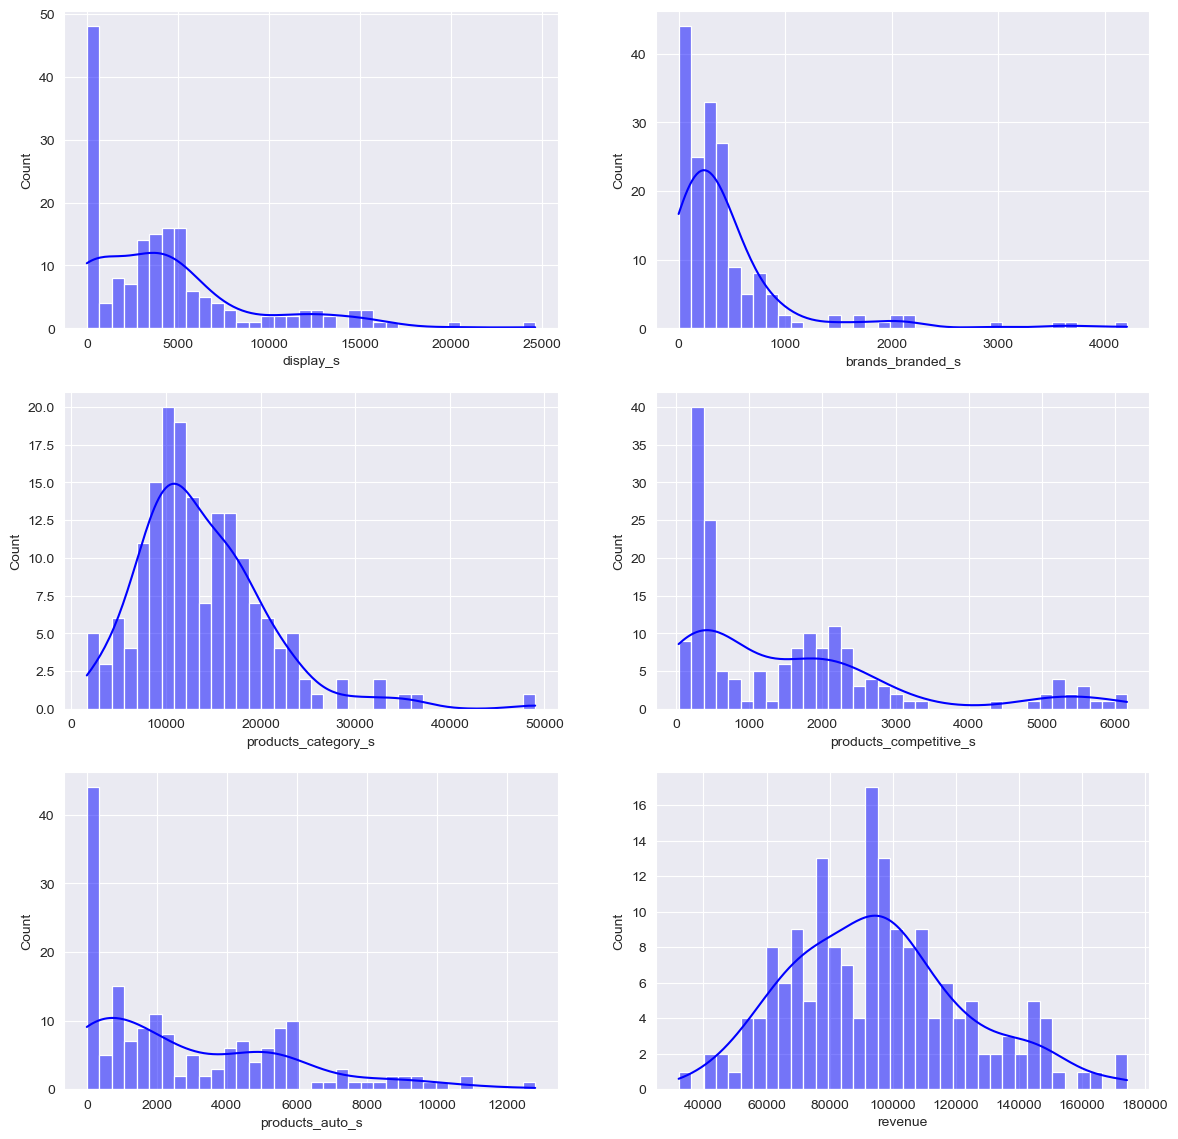

In [96]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
sns.histplot(df_no_date['display_s'], stat='count', kde=True, bins=int(180/5), ax=axes[0, 0], color = 'blue')
sns.histplot(df_no_date['brands_branded_s'], kde=True, bins=int(180/5), ax=axes[0, 1], color = 'blue')
sns.histplot(df_no_date['products_category_s'], kde=True, bins=int(180/5), ax=axes[1, 0], color = 'blue')
sns.histplot(df_no_date['products_competitive_s'], kde=True, bins=int(180/5), ax=axes[1, 1], color = 'blue')
sns.histplot(df_no_date['products_auto_s'], stat='count', kde=True, bins=int(180/5), ax=axes[2, 0], color = 'blue')
sns.histplot(df_no_date['revenue'], kde=True, bins=int(180/5), ax=axes[2,1], color = 'blue')

The spread of the KDE plot, along with the data above, suggests the variance is sufficient.
Most data is close to normal with a skew or slight bimodality, with the exception of
products_category_s, which has a large number of zeros.

<Axes: >

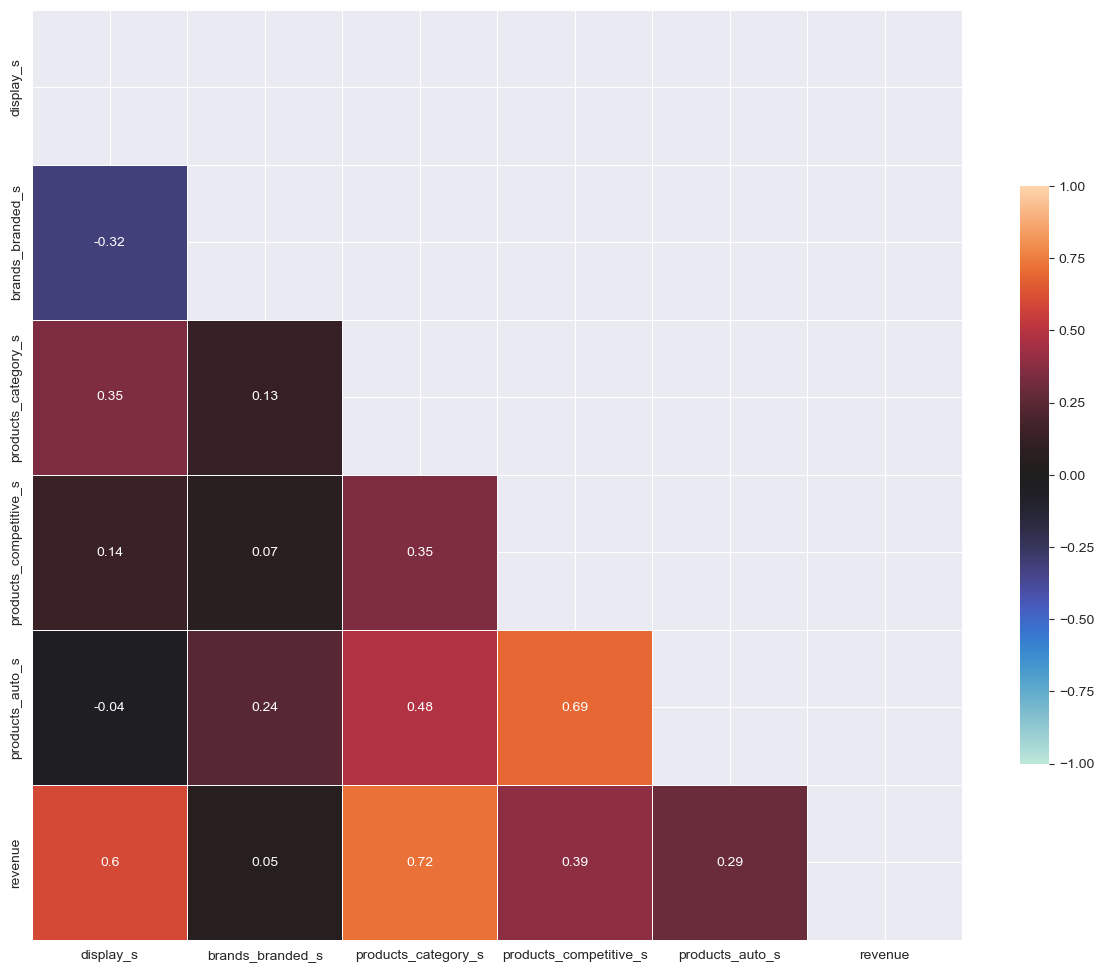

In [97]:
corr = df_no_date.corr(method="pearson").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.color_palette('icefire', as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Both revenue and units a have weak to moderate correlation with brands_competitive_s and products_branded_s,
weak correlations with brands_branded_s and products_category_s, and little to no correlation
with display_s, products_competitive_s, and products_auto_s.

In [98]:
corr.describe()

,display_s,brands_branded_s,products_category_s,products_competitive_s,products_auto_s,revenue
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.288333,0.195000,0.505000,0.440000,0.443333,0.508333
std,0.470592,0.437299,0.310016,0.350314,0.366206,0.336655
min,-0.320000,-0.320000,0.130000,0.070000,-0.040000,0.050000
25%,0.005000,0.055000,0.350000,0.192500,0.252500,0.315000
50%,0.245000,0.100000,0.415000,0.370000,0.385000,0.495000
75%,0.537500,0.212500,0.660000,0.615000,0.637500,0.690000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This section checks for outliers and approximates some idea of how extreme they are.
However, in Robyn, its converge() function that runs within the robyn_run() model
automatically winsorizes (adjusts upper and lower bounds of data input). This is just
a diagnostic if the model output is abnormal.

In [99]:
lower_q = df_no_date.quantile(0.25)
upper_q = df_no_date.quantile(0.75)
iqr = upper_q - lower_q
lower_bound = lower_q - (1.5 * iqr)
upper_bound = upper_q + (1.5 * iqr)
outliers = df_no_date[(df_no_date < lower_bound) | (df_no_date > upper_bound)]
print("Percentage Outliers")
print(outliers.count()/len(df_no_date))

Percentage Outliers
display_s                 0.058140
brands_branded_s          0.093023
products_category_s       0.040698
products_competitive_s    0.087209
products_auto_s           0.005814
revenue                   0.017442
dtype: float64


These should not be of much concern to the Robyn model

These two modules make html reports that are quite good and can supplement for an EDA if the EDA is not available.
In addition, I chose them because they do a good Time Series analysis and export it.

In [100]:
# profile_y = ydata_prof(df, title="Initial EDA")
# profile_y.to_file("basic_eda.html")

In [101]:
# profile_pd = pd_prof(df, tsmode=True, sortby="DATE", title='Time Series EDA')
# profile_pd.to_file("time_series_eda.html")

This dataset is sufficient for Cassandra's purposes.

In [102]:
df.to_csv('eo_cassandra.csv', index=False)